In [1]:
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.6 MB/s eta 0:00:00


**STEP1: Load google-drive, and libraries**

In [2]:
# Mounting google drive if it is already not mounted
def LoadGoogleDrive(googleDriveDir):
  # Link Google Drive
  import os
  # Check if Google Drive is already mounted
  if not os.path.exists(googleDriveDir + "/MyDrive"):
      print("Mounting Google Drive...")
      from google.colab import drive
      drive.mount(googleDriveDir)
  else:
      print("Google Drive is already mounted!")

from google.colab import drive
googleDriveFolder = "/content/drive"
LoadGoogleDrive(googleDriveFolder)

Mounting Google Drive...
Mounted at /content/drive


In [3]:
import sys
import import_ipynb

# 1. Set path to the directory where mylib.ipynb is located
lib_path = '/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib'
sys.path.append(lib_path)
# 2. Change current working directory to that path
%cd "$lib_path"

# 3. Now import the notebook
from app_lib import *
from features_analysis import *


/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib


**STEP2: Load data**

In [6]:
ip_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/P_HINTS6/op_data/merged_importance_matrics.xlsx"
ip_sheet_name = 'importance_matrix_with_category'
df_orig = load_data(verbose_level=1, ip_file_path=ip_file_path, ip_sheet_name=ip_sheet_name)


Ip File Path: /content/drive/MyDrive/Colab Notebooks/P_HINTS6/op_data/merged_importance_matrics.xlsx
 SheetName: importance_matrix_with_category
df_orig.shape: (26, 9)


In [7]:
df = df_orig.copy()
df.sample(3)

,feature,category,alias,mean_abs_shap_xgb,mean_shap_xgb,mean_abs_shap_tabnet,mean_shap_tabnet,mean_abs_shap_lr,mean_shap_lr
11,GeneralHealth_Good,Clinical Health,Good General Health,0.639183,-0.212654,0.194369,0.007260,0.212826,0.004039
8,FreqGoProvider,Health Behaviors,Number of Doctor Visits,0.087216,-0.017986,0.005225,0.001073,0.008462,-0.000160
2,AverageTimeSitting,Health Behaviors,Avg Daily Sitting Time,0.092323,-0.025193,0.008084,0.000786,0.004234,-0.000523


In [8]:
# Select and rename columns for display
importance_df = df[[
    "alias",
    "mean_abs_shap_xgb",
    "mean_abs_shap_tabnet",
    "mean_abs_shap_lr"
]].rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})

# ✅ Now sort using the new column name
importance_df = importance_df.sort_values(
    by="XGBoost SHAP Importance", ascending=False
).reset_index(drop=True)

# Display the styled table
importance_df.style.bar(
    subset=[
        "XGBoost SHAP Importance",
        "TabNet SHAP Importance",
        "Logistic Regression SHAP Importance"
    ],
    color="#5fba7d"
)

,Feature,XGBoost SHAP Importance,TabNet SHAP Importance,Logistic Regression SHAP Importance
0,Never Smoked,1.164264,0.158138,0.184439
1,Very Good General Health,0.783248,0.206560,0.216932
2,Good General Health,0.639183,0.194369,0.212826
3,Age (Yrs),0.607712,0.014519,0.022672
4,Former Smoker,0.505732,0.105102,0.134880
5,Excellent General Health,0.340937,0.091116,0.095996
6,Fair General Health,0.316367,0.067000,0.090079
7,Currently Smokes (Cigarettes),0.315986,0.048465,0.072960
8,Body Mass Index,0.093242,0.005761,0.006162
9,Avg Daily Sitting Time,0.092323,0.008084,0.004234


In [9]:
# Select and rename columns
importance_df = df[[
    "alias",
    "mean_abs_shap_xgb",
    "mean_abs_shap_tabnet",
    "mean_abs_shap_lr"
]].rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})

# Sort by importance (you can change the sorting model if desired)
importance_df = importance_df.sort_values(
    by="XGBoost SHAP Importance", ascending=False
).reset_index(drop=True)

# Display with light-to-dark green gradient
importance_df.style.background_gradient(
    subset=[
        "XGBoost SHAP Importance",
        "TabNet SHAP Importance",
        "Logistic Regression SHAP Importance"
    ],
    cmap="Greens"
)

,Feature,XGBoost SHAP Importance,TabNet SHAP Importance,Logistic Regression SHAP Importance
0,Never Smoked,1.164264,0.158138,0.184439
1,Very Good General Health,0.783248,0.206560,0.216932
2,Good General Health,0.639183,0.194369,0.212826
3,Age (Yrs),0.607712,0.014519,0.022672
4,Former Smoker,0.505732,0.105102,0.134880
5,Excellent General Health,0.340937,0.091116,0.095996
6,Fair General Health,0.316367,0.067000,0.090079
7,Currently Smokes (Cigarettes),0.315986,0.048465,0.072960
8,Body Mass Index,0.093242,0.005761,0.006162
9,Avg Daily Sitting Time,0.092323,0.008084,0.004234


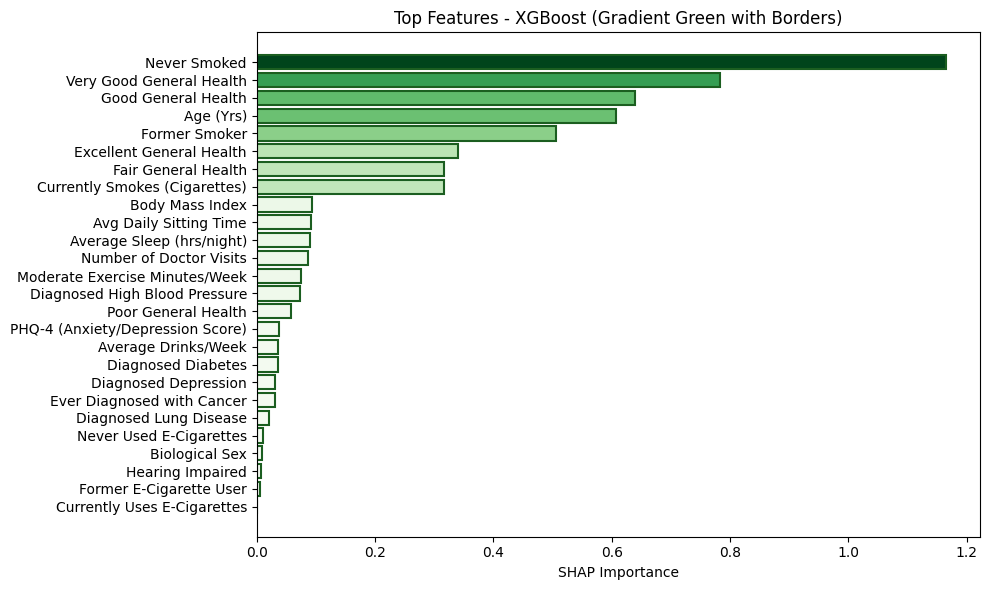

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot top N features
top_n = 26
plot_df = importance_df.head(top_n)

# Normalize values for color mapping
values = plot_df["XGBoost SHAP Importance"].values
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.Greens(norm(values))

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    plot_df["Feature"],
    values,
    color=colors,
    edgecolor="#1b5e20",   # dark green border
    linewidth=1.5
)

# Style
plt.gca().invert_yaxis()
plt.xlabel("SHAP Importance")
plt.title("Top Features - XGBoost (Gradient Green with Borders)")
plt.tight_layout()
plt.show()


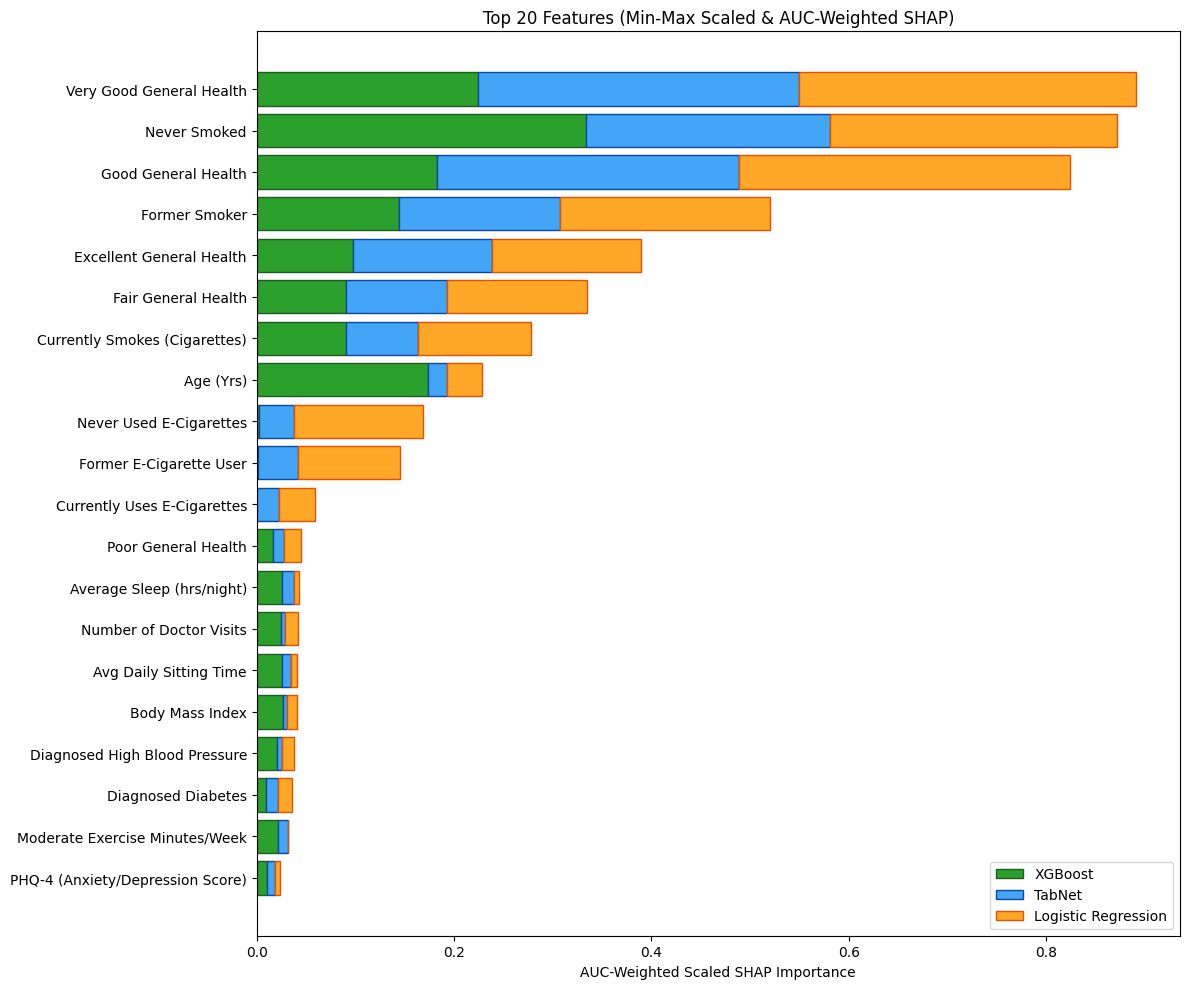

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Rename for easier access
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

# STEP 2: Min-max scale SHAP values for fair comparison
scaler = MinMaxScaler()
scaled_df = importance_df.copy()
scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]] = scaler.fit_transform(scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]])

# STEP 3: Apply AUC scores and compute weights
auc_scores = {
    "XGBoost": 0.78,
    "TabNet": 0.76,
    "Logistic Regression": 0.80
}
total_auc = sum(auc_scores.values())
weights = {k: v / total_auc for k, v in auc_scores.items()}

# STEP 4: Compute weighted importance
scaled_df["Weighted Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * weights["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * weights["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * weights["Logistic Regression"]
)

# STEP 5: Pick top 20 features
top_df = scaled_df.sort_values(by="Weighted Importance", ascending=False).head(20)

# STEP 6: Plot
features = top_df["Feature"]
xgb_vals = top_df["XGBoost SHAP Importance"].values * weights["XGBoost"]
tabnet_vals = top_df["TabNet SHAP Importance"].values * weights["TabNet"]
lr_vals = top_df["Logistic Regression SHAP Importance"].values * weights["Logistic Regression"]

plt.figure(figsize=(12, 10))
plt.barh(features, xgb_vals, label="XGBoost", color="#2ca02c", edgecolor="#1b5e20")
plt.barh(features, tabnet_vals, left=xgb_vals, label="TabNet", color="#42a5f5", edgecolor="#0d47a1")
plt.barh(features, lr_vals, left=xgb_vals + tabnet_vals, label="Logistic Regression", color="#ffa726", edgecolor="#e65100")

plt.gca().invert_yaxis()
plt.xlabel("AUC-Weighted Scaled SHAP Importance")
plt.title("Top 20 Features (Min-Max Scaled & AUC-Weighted SHAP)")
plt.legend()
plt.tight_layout()
plt.show()


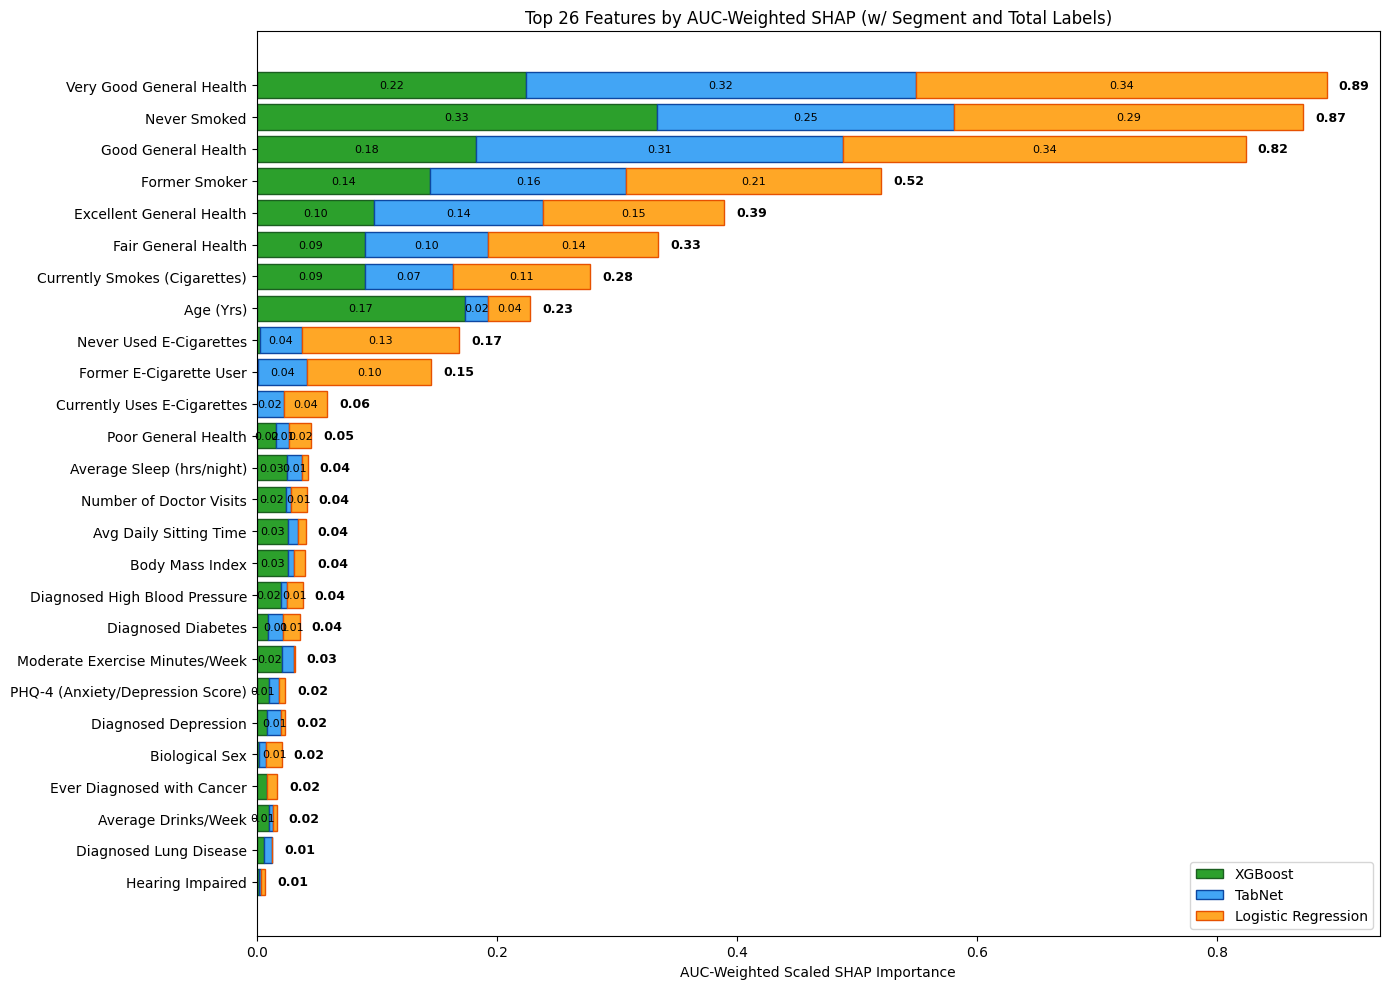

In [13]:
# STEP 2: Prepare and scale data
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

# Min-max scale SHAP values
scaler = MinMaxScaler()
scaled_df = importance_df.copy()
scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]] = scaler.fit_transform(scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]])

# AUC weighting
auc_scores = {
    "XGBoost": 0.78,
    "TabNet": 0.76,
    "Logistic Regression": 0.80
}
total_auc = sum(auc_scores.values())
weights = {k: v / total_auc for k, v in auc_scores.items()}

# Weighted importance
scaled_df["Weighted Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * weights["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * weights["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * weights["Logistic Regression"]
)

# Select top 20 features
top_df = scaled_df.sort_values(by="Weighted Importance", ascending=False).head(26)

# Prepare values
features = top_df["Feature"]
xgb_vals = top_df["XGBoost SHAP Importance"].values * weights["XGBoost"]
tabnet_vals = top_df["TabNet SHAP Importance"].values * weights["TabNet"]
lr_vals = top_df["Logistic Regression SHAP Importance"].values * weights["Logistic Regression"]
total_vals = xgb_vals + tabnet_vals + lr_vals

# Plot
plt.figure(figsize=(14, 10))
bars1 = plt.barh(features, xgb_vals, label="XGBoost", color="#2ca02c", edgecolor="#1b5e20")
bars2 = plt.barh(features, tabnet_vals, left=xgb_vals, label="TabNet", color="#42a5f5", edgecolor="#0d47a1")
bars3 = plt.barh(features, lr_vals, left=xgb_vals + tabnet_vals, label="Logistic Regression", color="#ffa726", edgecolor="#e65100")

# Add segment labels
for bars, values in zip([bars1, bars2, bars3], [xgb_vals, tabnet_vals, lr_vals]):
    for bar, val in zip(bars, values):
        if val > 0.01:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                     f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

# Add total label at end of bar
for i, (total, xgb, tab, lr) in enumerate(zip(total_vals, xgb_vals, tabnet_vals, lr_vals)):
    left = xgb + tab + lr
    plt.text(left + 0.01, i, f"{total:.2f}", va='center', fontsize=9, color='black', fontweight='bold')

# Final styling
plt.gca().invert_yaxis()
plt.xlabel("AUC-Weighted Scaled SHAP Importance")
plt.title("Top 26 Features by AUC-Weighted SHAP (w/ Segment and Total Labels)")
plt.legend()
plt.tight_layout()
plt.show()

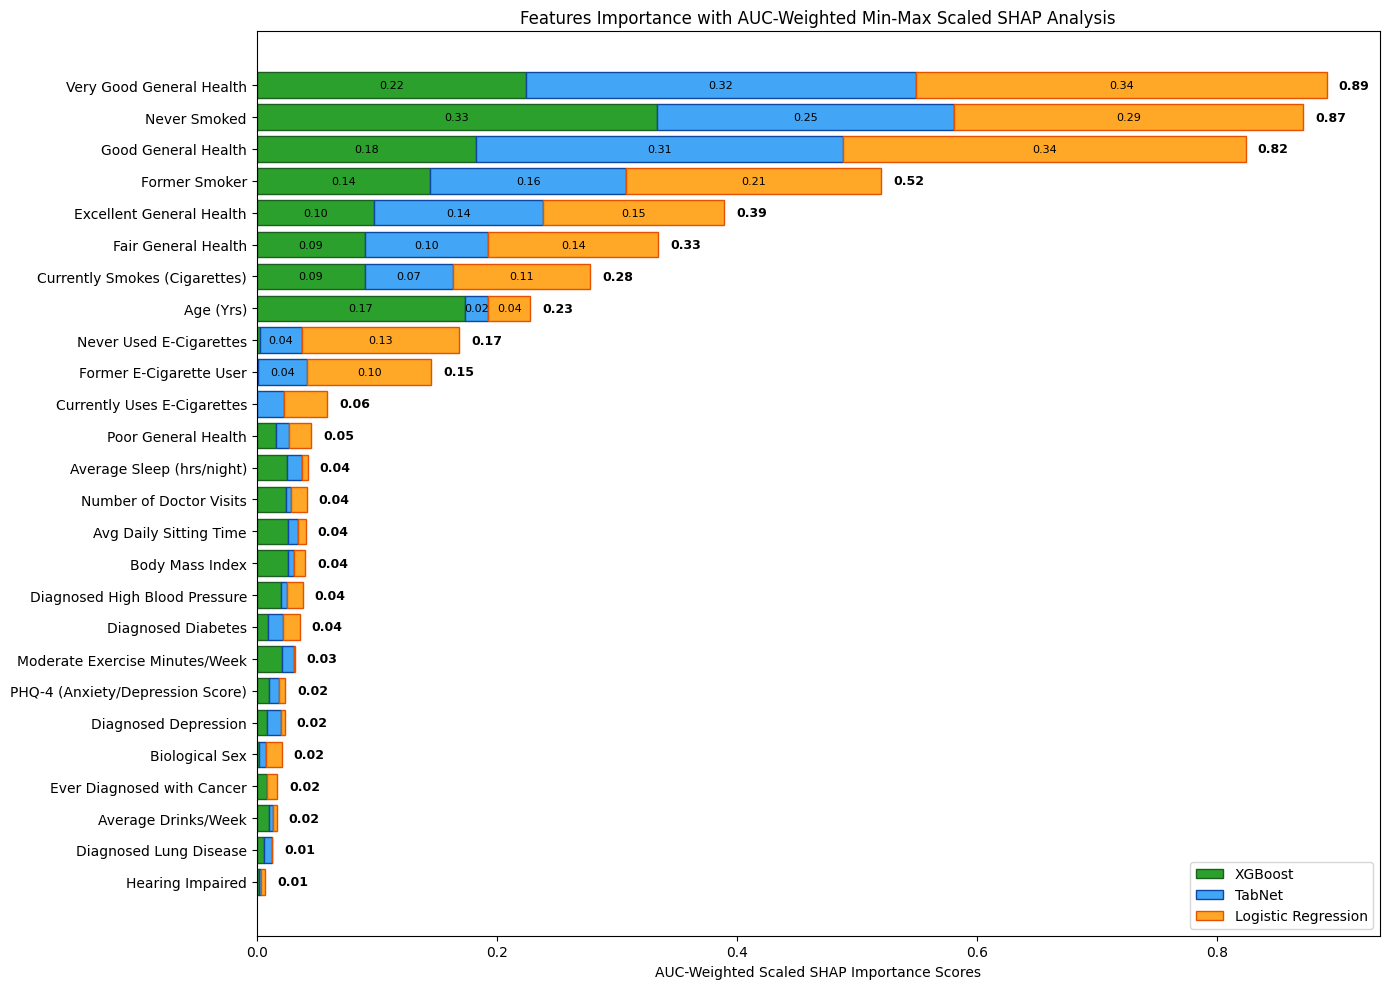

In [14]:
# STEP 2: Prepare and scale data
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

# Min-max scale SHAP values
scaler = MinMaxScaler()
scaled_df = importance_df.copy()
scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]] = scaler.fit_transform(scaled_df[[
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]])

# AUC weighting
auc_scores = {
    "XGBoost": 0.78,
    "TabNet": 0.76,
    "Logistic Regression": 0.80
}
total_auc = sum(auc_scores.values())
weights = {k: v / total_auc for k, v in auc_scores.items()}

# Weighted importance
scaled_df["Weighted Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * weights["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * weights["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * weights["Logistic Regression"]
)

# Select top 20 features
top_df = scaled_df.sort_values(by="Weighted Importance", ascending=False).head(26)

# Prepare values
features = top_df["Feature"]
xgb_vals = top_df["XGBoost SHAP Importance"].values * weights["XGBoost"]
tabnet_vals = top_df["TabNet SHAP Importance"].values * weights["TabNet"]
lr_vals = top_df["Logistic Regression SHAP Importance"].values * weights["Logistic Regression"]
total_vals = xgb_vals + tabnet_vals + lr_vals

# Plot
plt.figure(figsize=(14, 10))
bars1 = plt.barh(features, xgb_vals, label="XGBoost", color="#2ca02c", edgecolor="#1b5e20")
bars2 = plt.barh(features, tabnet_vals, left=xgb_vals, label="TabNet", color="#42a5f5", edgecolor="#0d47a1")
bars3 = plt.barh(features, lr_vals, left=xgb_vals + tabnet_vals, label="Logistic Regression", color="#ffa726", edgecolor="#e65100")

# Add segment labels (only if total >= 0.06)
for i, (xgb, tab, lr, total) in enumerate(zip(xgb_vals, tabnet_vals, lr_vals, total_vals)):
    if total > 0.06:
        bars = [bars1[i], bars2[i], bars3[i]]
        values = [xgb, tab, lr]
        for bar, val in zip(bars, values):
            if val > 0.01:
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')


# Add total label at end of bar
for i, (total, xgb, tab, lr) in enumerate(zip(total_vals, xgb_vals, tabnet_vals, lr_vals)):
    left = xgb + tab + lr
    plt.text(left + 0.01, i, f"{total:.2f}", va='center', fontsize=9, color='black', fontweight='bold')

# Final styling
plt.gca().invert_yaxis()
plt.xlabel("AUC-Weighted Scaled SHAP Importance Scores")
plt.title("Features Importance with AUC-Weighted Min-Max Scaled SHAP Analysis")
plt.legend()
plt.tight_layout()
plt.show()

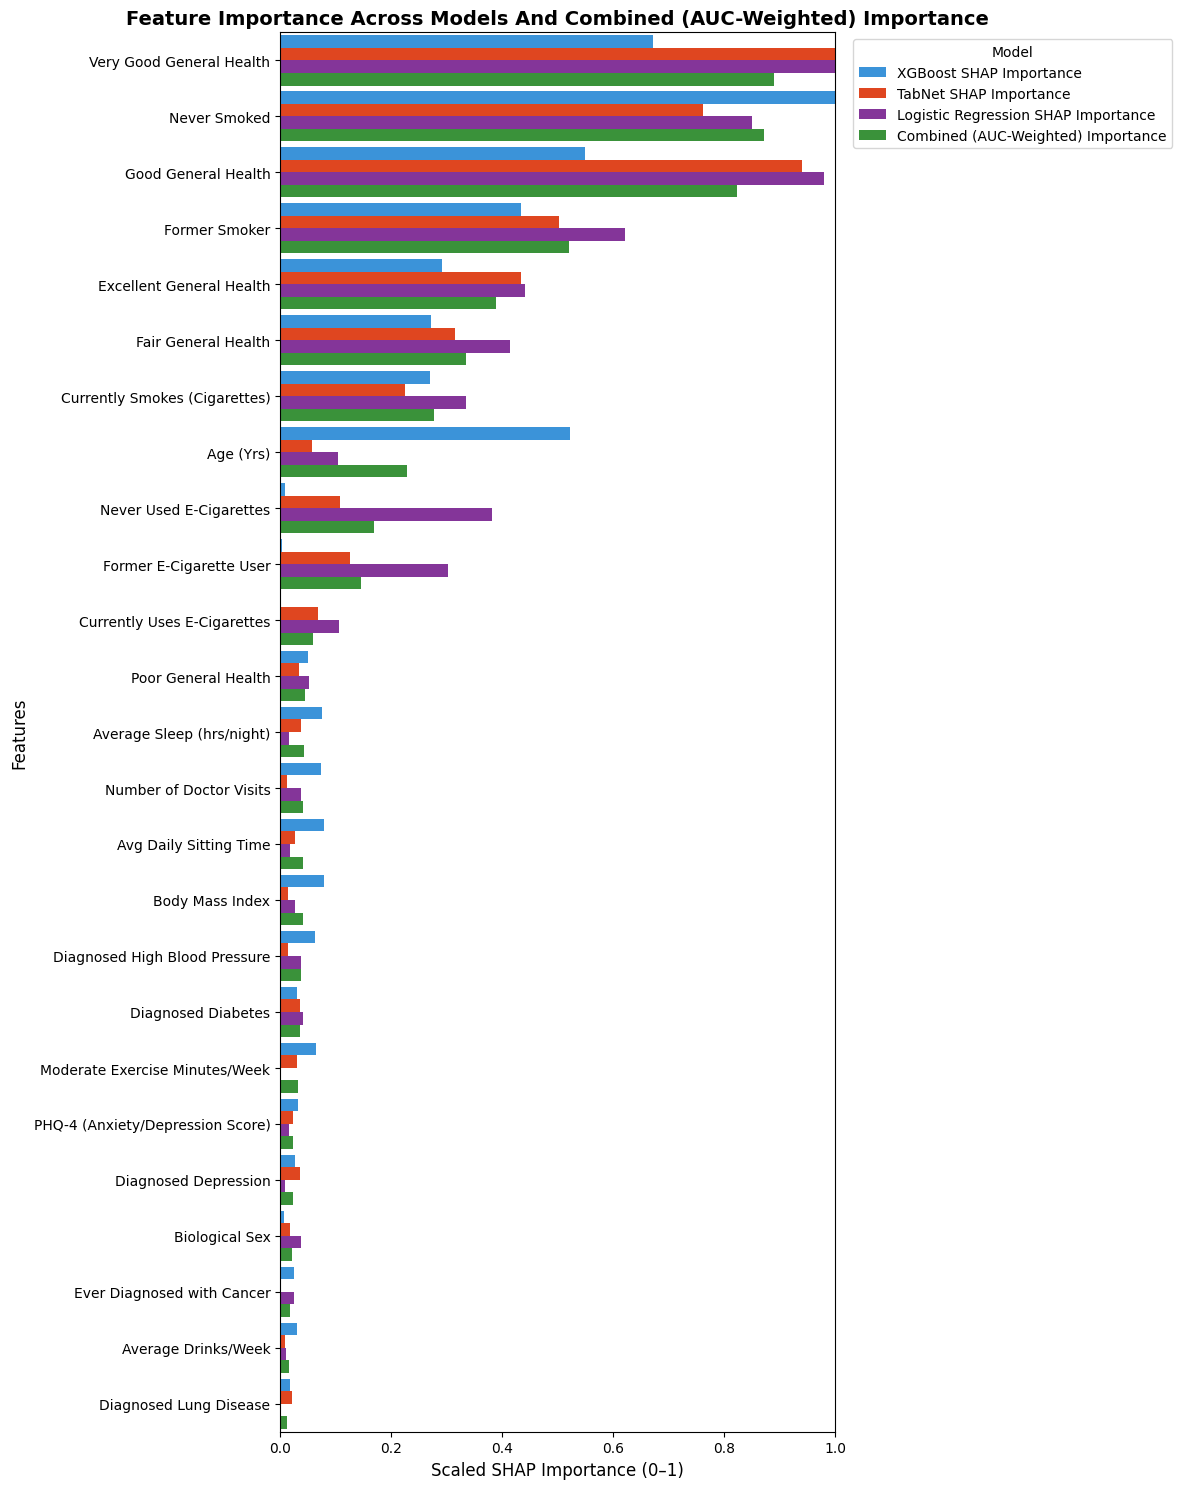

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- STEP 1: Prepare & Scale Data ---
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

# Min–max scale per model
scaler = MinMaxScaler()
cols = ["XGBoost SHAP Importance", "TabNet SHAP Importance", "Logistic Regression SHAP Importance"]
scaled_df = importance_df.copy()
scaled_df[cols] = scaler.fit_transform(scaled_df[cols])

# AUC weights
auc_scores = {"XGBoost": 0.78, "TabNet": 0.76, "Logistic Regression": 0.80}
w = {k: v / sum(auc_scores.values()) for k, v in auc_scores.items()}

# Combined (AUC-Weighted) importance
scaled_df["Combined (AUC-Weighted) Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * w["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * w["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * w["Logistic Regression"]
)

# --- STEP 2: Select top features ---
top_df = scaled_df.sort_values("Combined (AUC-Weighted) Importance", ascending=False).head(25)

# --- STEP 3: Melt Data for Plotting ---
plot_df = top_df[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance",
    "Combined (AUC-Weighted) Importance"
]].melt(id_vars="Feature", var_name="Model", value_name="Importance")

feature_order = top_df["Feature"]

# --- STEP 4: Custom Colors (swapped Logistic Regression & Combined colors) ---
custom_colors = {
    "XGBoost SHAP Importance": "#2196F3",             # blue
    "TabNet SHAP Importance": "#ff3300",              # red-orange
    "Logistic Regression SHAP Importance": "#8E24AA", # purple
    "Combined (AUC-Weighted) Importance": "#2ca02c"   # green
}

# --- STEP 5: Plot with Increased Bar Width ---
plt.figure(figsize=(12, 15))
ax = sns.barplot(
    data=plot_df,
    x="Importance",
    y="Feature",
    hue="Model",
    order=feature_order,
    palette=custom_colors,
    width=0.9
)

# Legend styling
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

# Axis styling
plt.xlim(0, 1)
plt.xlabel("Scaled SHAP Importance (0–1)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance Across Models And Combined (AUC-Weighted) Importance", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


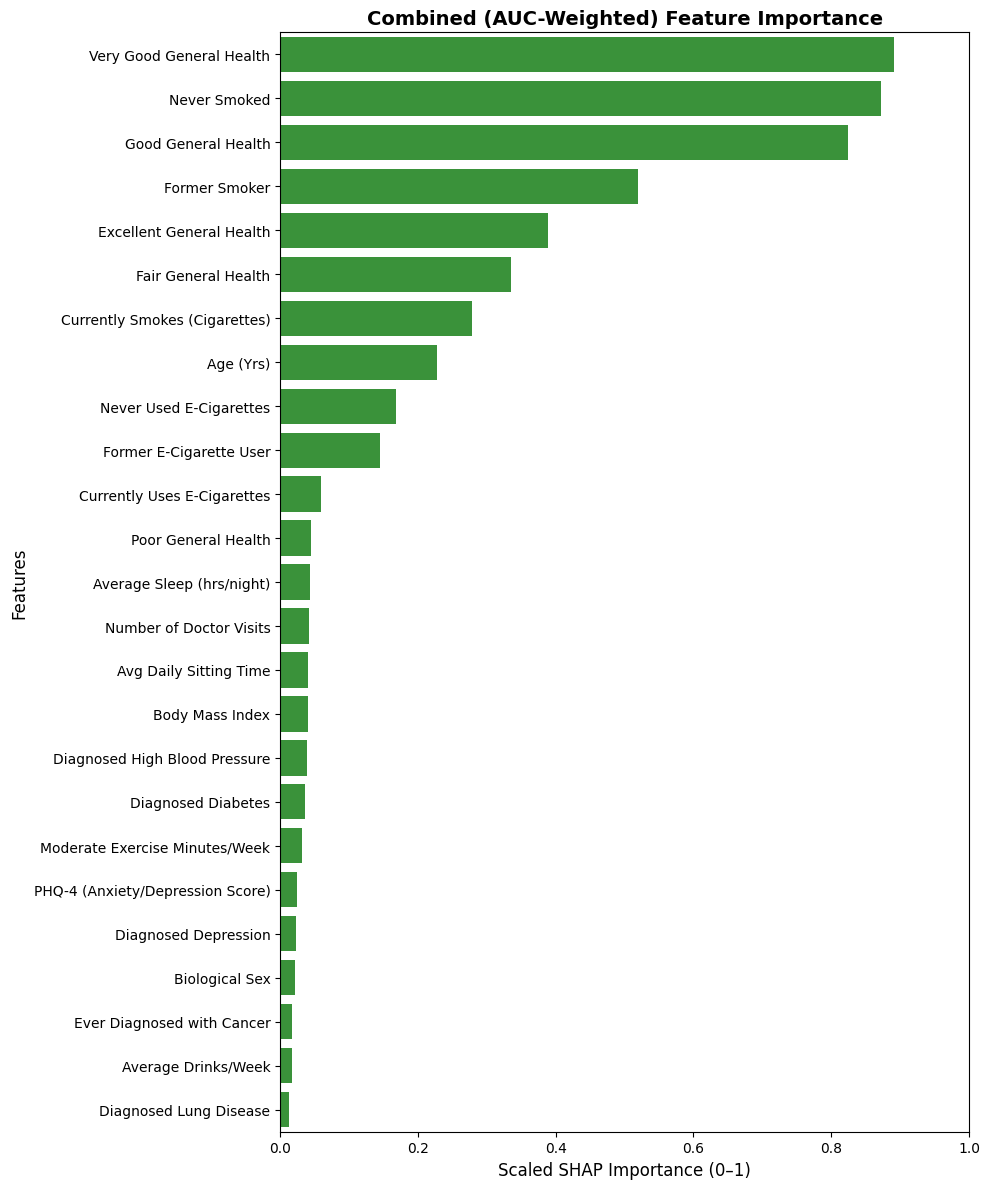

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- STEP 1: Prepare & Scale Data ---
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

# Min–max scale per model
scaler = MinMaxScaler()
cols = ["XGBoost SHAP Importance", "TabNet SHAP Importance", "Logistic Regression SHAP Importance"]
scaled_df = importance_df.copy()
scaled_df[cols] = scaler.fit_transform(scaled_df[cols])

# AUC weights
auc_scores = {"XGBoost": 0.78, "TabNet": 0.76, "Logistic Regression": 0.80}
w = {k: v / sum(auc_scores.values()) for k, v in auc_scores.items()}

# Combined (AUC-Weighted) importance
scaled_df["Combined (AUC-Weighted) Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * w["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * w["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * w["Logistic Regression"]
)

# --- STEP 2: Select top features ---
top_df = scaled_df.sort_values("Combined (AUC-Weighted) Importance", ascending=False).head(25)

# --- STEP 3: Plot ONLY combined importance ---
plt.figure(figsize=(10, 12))
sns.barplot(
    data=top_df,
    x="Combined (AUC-Weighted) Importance",
    y="Feature",
    color="#2ca02c",   # green
    width=0.8
)

# Labels & styling
plt.xlim(0, 1)
plt.xlabel("Scaled SHAP Importance (0–1)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Combined (AUC-Weighted) Feature Importance", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


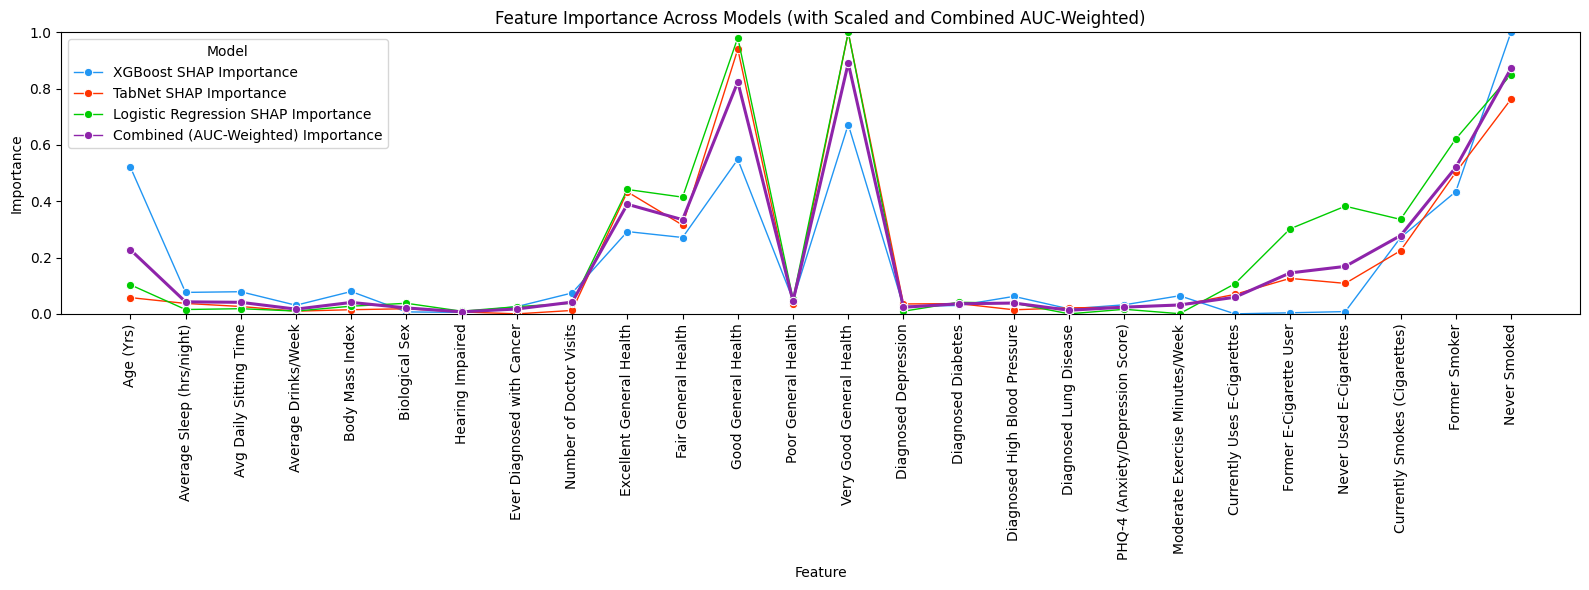

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ===== 1) Prep & scale =====
importance_df = df.rename(columns={
    "alias": "Feature",
    "mean_abs_shap_xgb": "XGBoost SHAP Importance",
    "mean_abs_shap_tabnet": "TabNet SHAP Importance",
    "mean_abs_shap_lr": "Logistic Regression SHAP Importance"
})[[
    "Feature",
    "XGBoost SHAP Importance",
    "TabNet SHAP Importance",
    "Logistic Regression SHAP Importance"
]]

scaler = MinMaxScaler()
cols = ["XGBoost SHAP Importance", "TabNet SHAP Importance", "Logistic Regression SHAP Importance"]
scaled_df = importance_df.copy()
scaled_df[cols] = scaler.fit_transform(scaled_df[cols])

# AUC weights
auc_scores = {"XGBoost": 0.78, "TabNet": 0.76, "Logistic Regression": 0.80}
w = {k: v / sum(auc_scores.values()) for k, v in auc_scores.items()}

# Combined (AUC-weighted) Importance
scaled_df["Combined (AUC-Weighted) Importance"] = (
    scaled_df["XGBoost SHAP Importance"] * w["XGBoost"] +
    scaled_df["TabNet SHAP Importance"] * w["TabNet"] +
    scaled_df["Logistic Regression SHAP Importance"] * w["Logistic Regression"]
)

# Keep feature order
feature_order = scaled_df["Feature"]

# Melt for plotting
plot_df = scaled_df.melt(
    id_vars="Feature",
    value_vars=[
        "XGBoost SHAP Importance",
        "TabNet SHAP Importance",
        "Logistic Regression SHAP Importance",
        "Combined (AUC-Weighted) Importance"
    ],
    var_name="Model",
    value_name="Importance"
)

# ===== 2) Plot with thin lines =====
plt.figure(figsize=(16, 6))
palette_OLD = {
    "XGBoost SHAP Importance": "#4CAF50",        # green
    "TabNet SHAP Importance": "#2196F3",         # blue
    "Logistic Regression SHAP Importance": "#FF9800",  # orange
    "Combined (AUC-Weighted) Importance": "#8E24AA"         # purple
}

palette = {
    "XGBoost SHAP Importance": "#2196F3",       # medium green
    "TabNet SHAP Importance": "#ff3300",        # bright blue
    "Logistic Regression SHAP Importance": "#00cc00",  # deep orange
    "Combined (AUC-Weighted) Importance": "#8E24AA"        # vivid purple
}


# Plot all models with thin lines
sns.lineplot(
    data=plot_df,
    x="Feature", y="Importance", hue="Model",
    palette=palette, marker="o", linewidth=1.0
)

# Make the Combined line thicker
ax = plt.gca()
for line, label in zip(ax.lines, [t.get_text() for t in ax.get_legend().get_texts()]):
    if "Combined" in label:
        line.set_linewidth(2.2)  # Slightly thicker
        line.set_zorder(3)       # On top

# Formatting
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance Across Models (with Scaled and Combined AUC-Weighted)")
plt.legend(title="Model", loc="upper left")
plt.tight_layout()
plt.show()
